In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import fft, signal
%matplotlib inline

x = np.arange(-10, 10, 0.1)

## Distortion
### nonlinear transfer functions

#### from DAFX book
See https://dsp.stackexchange.com/questions/13142/digital-distortion-effect-algorithm

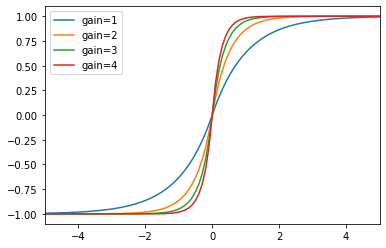

In [127]:
def distortion_dafx(x, gain=1, makeup=False):
    y = x * gain
    out = (y / np.absolute(y)) * (1-np.exp(-1*np.absolute(y)))
    if makeup:
        # correct for loss incurred but the saturation
        # divide the signal by the signal level if x=1
        out_m = (gain / np.absolute(gain)) * (1-np.exp(-1*np.absolute(gain)))
        return out / out_m
    else:
        return out

for i in [1, 2, 3, 4]:
    plt.plot(x, distortion_dafx(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### tanh

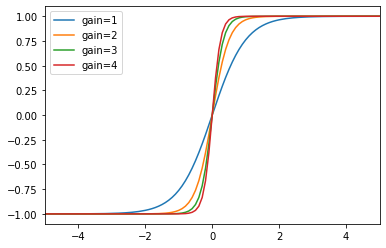

In [129]:
def tanh_alt(x, gain=1, makeup=False):
    y = x * gain
    out = 2 / (1 + np.exp(-2*y)) - 1
    if makeup:
        # correct for loss incurred but the saturation
        # divide the signal by the signal level if x=1
        out_m = 2 / (1 + np.exp(-2*gain)) - 1
        return out / out_m
    else:
        return out

#plt.plot(x, np.tanh(x), x, tanh_alt(x))
for i in [1, 2, 3, 4]:
    plt.plot(x, tanh_alt(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### sigmoid

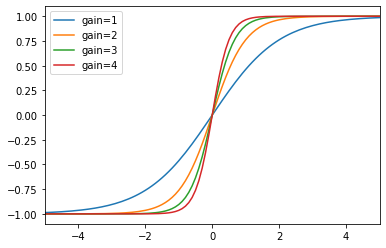

In [132]:
def sigmoid_bipolar(x, gain=1, makeup=False):
    y = x * gain
    out = (1 - np.exp(-y)) / (1 + np.exp(-y))
    if makeup:
        # correct for loss incurred but the saturation
        # divide the signal by the signal level if x=1
        out_m = (1 - np.exp(-gain)) / (1 + np.exp(-gain))
        return out / out_m
    else:
        return out

for i in [1, 2, 3, 4]:
    plt.plot(x, sigmoid_bipolar(x, gain=i), label='gain={}'.format(i))
plt.xlim(-5, 5)
plt.legend()

#### hard clipping

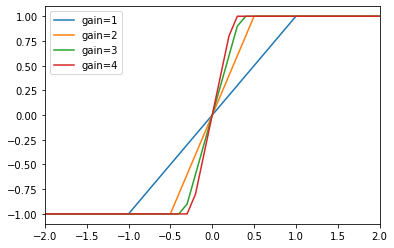

In [5]:
def hard_clipping(x, gain=1):
    y = x * gain
    return np.where(y > 1, 1, np.where(y < -1, -1, y))

for i in [1, 2, 3, 4]:
    plt.plot(x, hard_clipping(x, gain=i), label='gain={}'.format(i))
plt.xlim(-2, 2)
plt.legend()

#### polymonial

In [6]:
def distortion_poly(x, deg=3):
    if deg % 2 != 1:
        raise ValueError('polynomial degree {} must be odd integer'.format(deg))
    return np.where(
        x > 1, (deg - 1) / deg,
        np.where(
            x < -1, -(deg-1)/deg,
            x - x ** deg / deg
        )
    )

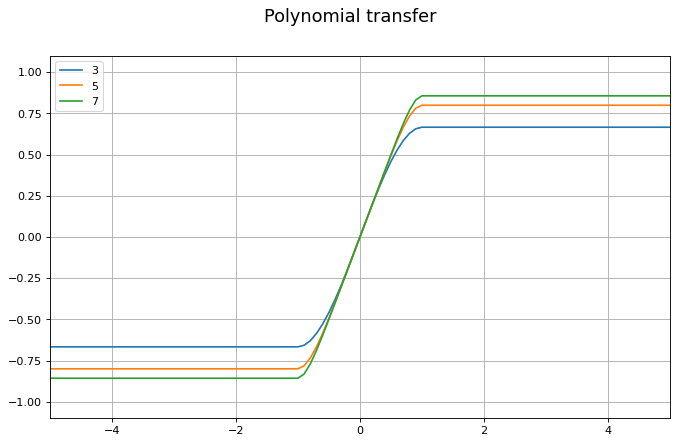

In [7]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Polynomial transfer', fontsize=16)
ax = fig.add_subplot(111)
for i in [3, 5, 7]:
    ax.plot(x, distortion_poly(x, i), label=i)
ax.set_xlim(-5, 5)
ax.set_ylim(-1.1, 1.1)
ax.grid(True)
ax.legend()

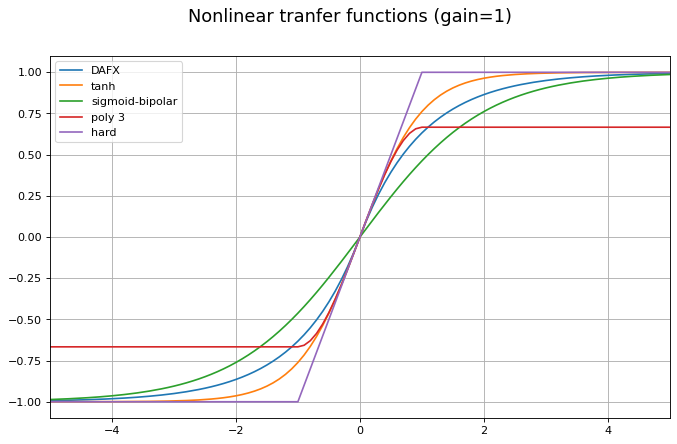

In [8]:
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Nonlinear tranfer functions (gain=1)', fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, distortion_dafx(x), label='DAFX')
ax.plot(x, np.tanh(x), label='tanh')
ax.plot(x, sigmoid_bipolar(x), label='sigmoid-bipolar')
ax.plot(x, distortion_poly(x, 3), label='poly 3')
ax.plot(x, hard_clipping(x), label='hard')
ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()

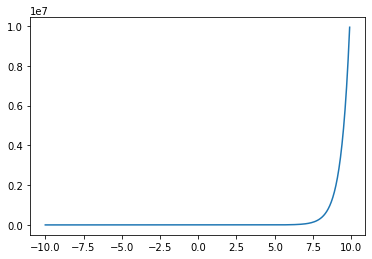

In [9]:
def shockley_diode(x, alpha=1.79, beta=0.2):
    return beta * (np.exp(alpha*x) - 1.0)

plt.plot(x, shockley_diode(x))

### Makeup gain
Investigate how much makeup gain is required for input=1 to give output=1

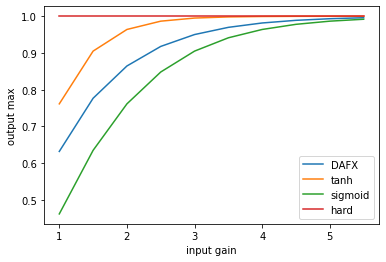

In [112]:
g = np.arange(1, 6, 0.5)
plt.plot(g, distortion_dafx(1, gain=g), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g), label='sigmoid')
plt.plot(g, hard_clipping(1, gain=g), label='hard')
plt.xlabel('input gain')
plt.ylabel('output max')
plt.legend()

There is some signal loss with all transfer functions, except the hard clipping, and it varies with the input gain applied. We should be able to adjust for this by calculating the the max output (from input signal=1) and then divide the distorted input by this factor.

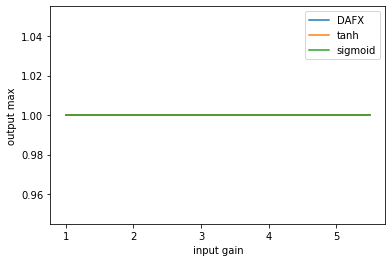

In [133]:
plt.plot(g, distortion_dafx(1, gain=g, makeup=True), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g, makeup=True), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g, makeup=True), label='sigmoid')
plt.xlabel('input gain')
plt.ylabel('output max')
plt.legend()

## Applied distortion

In [11]:
def sine_wave(x, freq, fs):
    return np.sin(2 * np.pi * x * freq / fs)

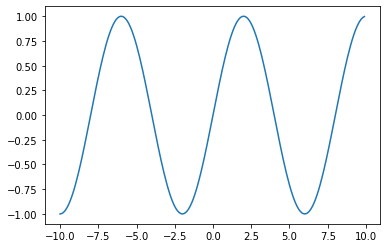

In [12]:
fs = 48000
freq = fs / 8
plt.plot(x, sine_wave(x, freq, fs))

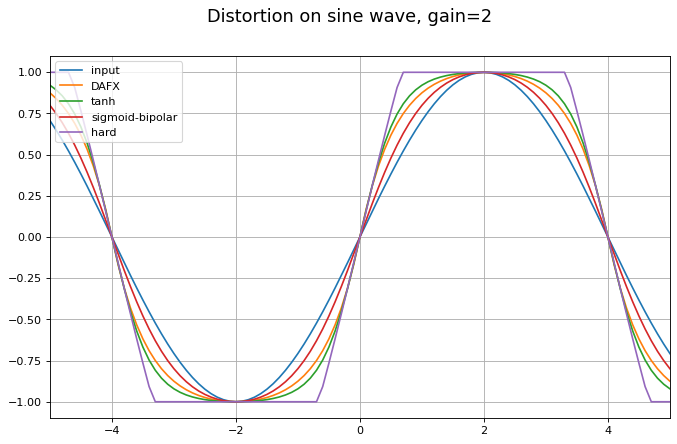

In [136]:
gain = 2
makeup = True
fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Distortion on sine wave, gain={}'.format(gain), fontsize=16)
ax = fig.add_subplot(111)
ax.plot(x, sine_wave(x, freq, fs), label='input')
ax.plot(x, distortion_dafx(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='DAFX')
ax.plot(x, tanh_alt(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='tanh')
ax.plot(x, sigmoid_bipolar(sine_wave(x, freq, fs), gain=gain, makeup=makeup), label='sigmoid-bipolar')
#ax.plot(x, distortion_poly(x, 3), label='poly 3')
ax.plot(x, hard_clipping(sine_wave(x, freq, fs), gain=gain), label='hard')
ax.set_xlim(-5, 5)
ax.grid(True)
ax.legend()

In [106]:
def plot_spectrum(data, fs, ax, power=True, log=False):
    n = len(data) 
    freq = fft.fft(data)
    freq = freq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
    mag = np.abs(freq) # Magnitude
    mag = mag / float(n)
    # power spectrum
    if power:
        mag = mag ** 2
        ax.set_ylabel('Power spectrum (dB)')
    else:
        ax.set_ylabel('Spectrum (dB)')
    if n % 2 > 0: # ffte odd 
        mag[1:len(mag)] = mag[1:len(mag)] * 2
    else:# fft even
        mag[1:len(mag) -1] = mag[1:len(mag) - 1] * 2

    freq_axis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
    ax.plot(freq_axis/1000.0, 10*np.log10(mag)) #Power spectrum
    if log:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlim(0.02, 20)
    ax.set_ylim(-200, 0)
    ax.set_xlabel('Frequency (kHz)')
    ax.set_title('Specturm')

def plot_spectrogram(data, fs, ax, db=True, log=False):
    frame = 512 #Number of point in the fft
    f, t, Sxx = signal.spectrogram(data, fs,window = signal.blackman(frame),nfft=frame)
    if db:
        ax.pcolormesh(t, f, 10*np.log10(Sxx), shading='auto') # dB spectrogram
        ax.set_title('Spectrogram dB')
    else:
        ax.pcolormesh(t, f, Sxx, shading='auto') # Linear spectrogram
        ax.set_title('Spectrogram linear')
    if log:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylim(0.02, 20000)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (sec)')

In [107]:
sine_hz = 440
sec = 3
t = np.linspace(0, sec, fs * sec)
y = np.sin(sine_hz * 2 * np.pi * t)

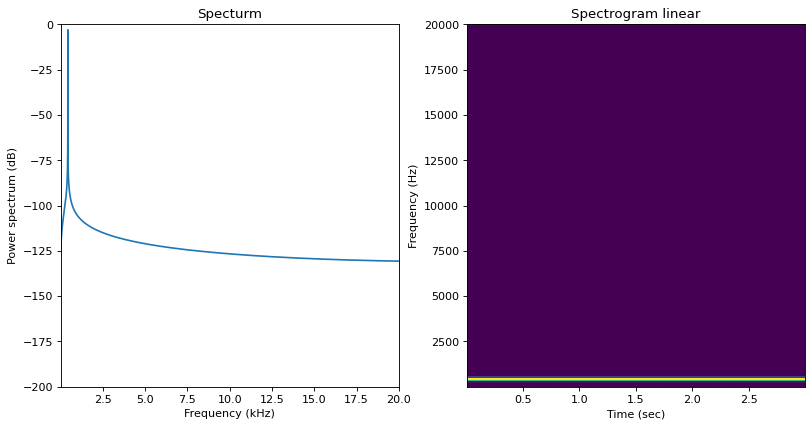

In [110]:
fig = plt.figure(figsize=(12, 6), dpi=80)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_spectrum(y, fs, ax1, power=True, log=False)
plot_spectrogram(y, fs, ax2, db=False, log=False)